In [1]:
import json
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from simulation import minimal_model as mm
from surrogate import neural_network

from sampling.grid import Grid, Grid_sparse
from sampling.random import Random
from sampling.lhs import LatinHyperCube, OrtogonalLatinHyperCube
from sampling.greedy_farpoint import GREEDYFP

from visualise import stream, surface

2024-06-27 11:28:24.994867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 11:28:25.798409: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def get_primes(n):
    out = list()
    sieve = [True] * (n+1)
    for p in range(2, n+1):
        if (sieve[p] and sieve[p]%2==1):
            out.append(p)
            for i in range(p, n+1, p):
                sieve[i] = False
    return out

In [4]:
g = 1.78
B_lim, D_lim = 2.9, 0.4
bounds = [(0, D_lim), (0, B_lim)]

# Experiments

In [5]:
from tqdm import tqdm

In [8]:
def mean_error(y_true, y_pred):
    return np.mean(y_true - y_pred)

def experiment(sampling_methods, n_requested_samples, ranges, g, hyper_parameters, folds = 10):

    results = pd.DataFrame(columns=['method', 'n', 'mse_run', 'mse_method', 'mae_run', 'mae_method', 'me_run', 'me_method', 'hp', 'uid', 'epochs', 'fold'])

    req_sqrt = [int(np.sqrt(n)) for n in n_requested_samples]
    primes = [get_primes(sq)[-1] for sq in req_sqrt]
    n_samples = [prime**2 for prime in primes]

    n_eval = 10**4
    D_true, B_true = Random.sample_stack(ranges, n_eval)
    true_dB_dt, true_dD_dt = mm.step(B_true, D_true, g, warm_up=0)
    # The same across all current experiments
    X_test = np.column_stack((B_true.flatten(), D_true.flatten(), np.repeat(g, (n_eval))))
    y_test = np.column_stack((true_dB_dt.flatten(), true_dD_dt.flatten()))

    # for method in tqdm(sampling_methods, desc='Methods: '):
    for method in sampling_methods:
        method_name = str(method.__name__)
        for i, n in tqdm(enumerate(n_samples)):
            refresh_max = int(n/10) if int(n/10) > 5 else 5

    	    # Run the methods N times and retrain per size N
            for fold in range(folds):
                D_points, B_points = method.sample_stack(ranges, n, refresh_count=refresh_max, scale=2)
                train_dB_dt, train_dD_dt = mm.step(B_points, D_points, g)
                X = np.column_stack([B_points.flatten(), D_points.flatten(), np.repeat(g, (n))])
                y = np.column_stack([train_dB_dt.flatten(), train_dD_dt.flatten()])

                X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True)
                NN = neural_network.NeuralNetwork(hyper_parameters)
                NN.train(X_train, y_train, X_val, y_val, verbose=False)

                y_true_pred = NN.predict(X_test, verbose=False)
                y_val_pred = NN.predict(X_val, verbose=False)

                new_row = pd.DataFrame([{
                    'method': method_name,
                    'n': n,
                    'mse_run': mean_squared_error(y_test, y_true_pred), # Unseen large random dataset.
                    'mse_method': mean_squared_error(y_val, y_val_pred), # Unseen already validated on set from method dataset.
                    'mae_run': mean_absolute_error(y_test, y_true_pred), # Unseen large random dataset.
                    'mae_method': mean_absolute_error(y_val, y_val_pred), # Unseen already validated on set from method dataset.
                    'me_run': mean_error(y_test, y_true_pred),
                    'me_method': mean_error(y_val, y_val_pred),
                    'hp': hyper_parameters,
                    'uid': NN.uid,
                    'epochs': len(NN.history.history['loss']),
                    'fold': fold
                }])
                results = pd.concat([results, new_row], ignore_index=True)
    results['mae_diff'] = np.abs(results['mae_method'] - results['mae_run'])
    results['mse_diff'] = np.abs(results['mse_method'] - results['mse_run'])

    results['bias_method'] = (results['me_method']**2) / results['mse_method']
    results['bias_run'] = (results['me_run']**2) / results['mse_run']
    return results

In [9]:
# All sampling methods instances you want to test.
sampling_methods = [Random, Grid, Grid_sparse, LatinHyperCube, OrtogonalLatinHyperCube, GREEDYFP]

# Approximations of N total samples. Should be cubes of a prime. Will be translated if it is not.
n_requested_samples = [25, 50, 121, 200, 529, 1849]

hp = {
    'units': [256, 256, 256, 128, 64],
    'act_fun': 'relu',
    'learning_rate': 0.005,
    'batch_size': 32,
    'l2_reg': 1e-4,
    'n_epochs': 400}

results = experiment(sampling_methods, n_requested_samples, bounds, g, hp, 10)

0it [00:00, ?it/s]/tmp/ipykernel_1384830/1125834742.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)
6it [36:51, 368.66s/it]


In [8]:
# prev = "20240610_114941"
# df1 = pd.read_csv(f"data/experiments/{prev}.csv", index_col='Unnamed: 0')

# prev = "20240608_164804"
# df2 = pd.read_csv(f"data/experiments/{prev}.csv", index_col='Unnamed: 0')

# df_double = pd.concat([df1, df2], ignore_index=True)

In [9]:
df = results.copy(deep=True)


In [23]:
prev = "no-seed_6-m_10-fold"
df_10 = pd.read_csv(f"data/experiments/exploration/{prev}.csv", index_col='index')

In [24]:
# hist = neural_network.load_history('20240610_114541')
# neural_network.plot_history(hist)

# uids = results[results['method'] == 'OrtogonalLatinHyperCube\'>']['uid'].values
# for uid in uids:
#     hist = neural_network.load_history(uid)
#     neural_network.plot_history(hist)

In [162]:
def plot_results_seaborn(results_total, methods, y_axis='mse'):
    translations = {
        'mse': "Mean Squared Error",
        'mae': "Mean Absolute Error"
    }
    axis_text = translations.get(y_axis, y_axis)

    results = results_total[results_total['method'].isin(methods)]

    # agg_method = df_10.groupby('n')[[f'{y_axis}_method']].agg(['min', 'mean'])
    # agg_run = df_10.groupby('n')[[f'{y_axis}_run']].agg(['min', 'mean'])
    # display(agg_run)
    # Create a new figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

    # Plot the first lineplot on the first axis
    # sns.lineplot(data=results, x='n', y='mse_method', hue='method', marker='o', ax=ax1)
    sns.lineplot(data=results, x='n', y=f'{y_axis}_run', hue='method', marker='o', err_style="bars", errorbar=("se"), ax=ax1)
    # sns.lineplot(agg_run, linestyle='--', ax=ax1)
    ax1.set_xlabel('Number of Samples (n)')
    ax1.set_ylabel(f'{axis_text} (Run)')
    ax1.set_title(f'{y_axis.capitalize()} Run vs Number of Samples for Different Methods')
    if y_axis not in ['bias']: 
        ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.grid(True)

    xticks = sorted(results['n'].unique())
    # xticks = np.concatenate([[0], xticks])
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([f'{x}' for x in xticks])
    # plt.tight_layout()

    # Show the plot
    # plt.show()

    # fig, ax2 = plt.subplots(1, 1, figsize=(6,6), sharex=True)

    # Plot the second lineplot on the second axis
    # sns.lineplot(data=results, x='n', y='mse_method', hue='method', marker='o', ax=ax2)
    sns.lineplot(data=results, x='n', y=f'{y_axis}_method', hue='method', marker='o', err_style="bars", errorbar=("se"), ax=ax2)
    # sns.lineplot(agg_method, linestyle='--', ax=ax2)
    ax2.set_xlabel('Number of Samples (n)')
    ax2.set_ylabel(f'{axis_text} (Method)')
    ax2.set_title(f'{y_axis.capitalize()} Method vs Number of Samples for Different Methods')
    if y_axis not in ['bias']: 
        ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.grid(True)

    # Set the x-ticks to show the exact x-values

    xticks = sorted(results['n'].unique())
    # xticks = np.concatenate([[0], xticks])
    ax2.set_xticks(xticks)
    ax2.set_xticklabels([f'{x}' for x in xticks])
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_diff_seaborn(results_total, methods, y_axis='mse'):
    translations = {
        'mse': "Mean Squared Error",
        'mae': "Mean Absolute Error"
    }
    axis_text = translations.get(y_axis, y_axis)

    results = results_total[results_total['method'].isin(methods)]

    # agg_method = df_10.groupby('n')[[f'{y_axis}_method']].agg(['min', 'mean'])
    # agg_run = df_10.groupby('n')[[f'{y_axis}_run']].agg(['min', 'mean'])
    # display(agg_run)
    # Create a new figure with two subplots
    fig, ax1 = plt.subplots(1, 1, figsize=(6,6))

    # Plot the first lineplot on the first axis
    # sns.lineplot(data=results, x='n', y='mse_method', hue='method', marker='o', ax=ax1)
    sns.lineplot(data=results, x='n', y=f'{y_axis}_diff', hue='method', marker='o', err_style="bars", errorbar=("se"), ax=ax1)
    # sns.lineplot(agg_run, linestyle='--', ax=ax1)
    ax1.set_xlabel('Number of Samples (n)')
    ax1.set_ylabel(f'{axis_text} difference between Method & Run')
    ax1.set_title(f'{y_axis.capitalize()} difference in Run & Method performance')
    if y_axis not in ['bias']: 
        ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.grid(True)

    xticks = sorted(results['n'].unique())
    # xticks = np.concatenate([[0], xticks])
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([f'{x}' for x in xticks])
    plt.tight_layout()

    plt.show()

In [163]:
df_10

,method,n,mse_run,mse_method,mae_run,mae_method,me_run,me_method,hp,uid,epochs,fold,mae_diff,mse_diff,bias_method,bias_run
0,Random,25,0.016759,0.018716,0.075323,0.077268,0.014439,-0.041127,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240626_130026,211,0,0.001945,1.956717e-03,0.090374,0.012439
1,Random,25,0.028479,0.019338,0.083736,0.069267,-0.042039,-0.026601,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240626_130036,162,1,0.014469,9.140903e-03,0.036593,0.062056
2,Random,25,0.023923,0.015792,0.076939,0.064744,-0.032851,-0.019635,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240626_130044,336,2,0.012195,8.130508e-03,0.024412,0.045111
3,Random,25,0.027670,0.018805,0.082942,0.070310,-0.038618,-0.023200,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240626_130058,187,3,0.012632,8.864630e-03,0.028623,0.053898
4,Random,25,0.029027,0.019892,0.084736,0.070879,-0.041826,-0.026410,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240626_130107,173,4,0.013857,9.134627e-03,0.035063,0.060267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,GREEDYFP_EQ,1849,0.000003,0.000003,0.000745,0.000843,0.000091,0.000094,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240627_115713,400,5,0.000098,6.613460e-07,0.002645,0.003137
416,GREEDYFP_EQ,1849,0.000003,0.000004,0.000796,0.000891,-0.000047,-0.000025,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240627_115919,400,6,0.000094,6.190191e-07,0.000157,0.000654
417,GREEDYFP_EQ,1849,0.000003,0.000004,0.000796,0.000934,-0.000134,-0.000101,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240627_120123,400,7,0.000138,1.097986e-06,0.002322,0.005529
418,GREEDYFP_EQ,1849,0.000003,0.000004,0.000823,0.000901,0.000108,0.000115,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240627_120324,400,8,0.000078,7.673961e-07,0.003214,0.003548


In [164]:
# df_10['bias_method'] = (df_10['me_method']**2) / df_10['mse_method']
# df_10['bias_run'] = (df_10['me_run']**2) / df_10['mse_run']

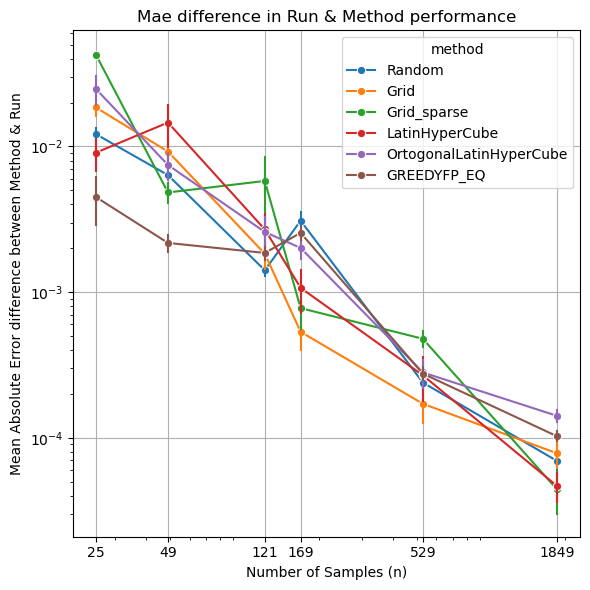

In [165]:
methods = ['Random', 'Grid', 'Grid_sparse', 'LatinHyperCube', 'OrtogonalLatinHyperCube', 'GREEDYFP_EQ'] # All samples
plot_diff_seaborn(df_10, methods, 'mae')

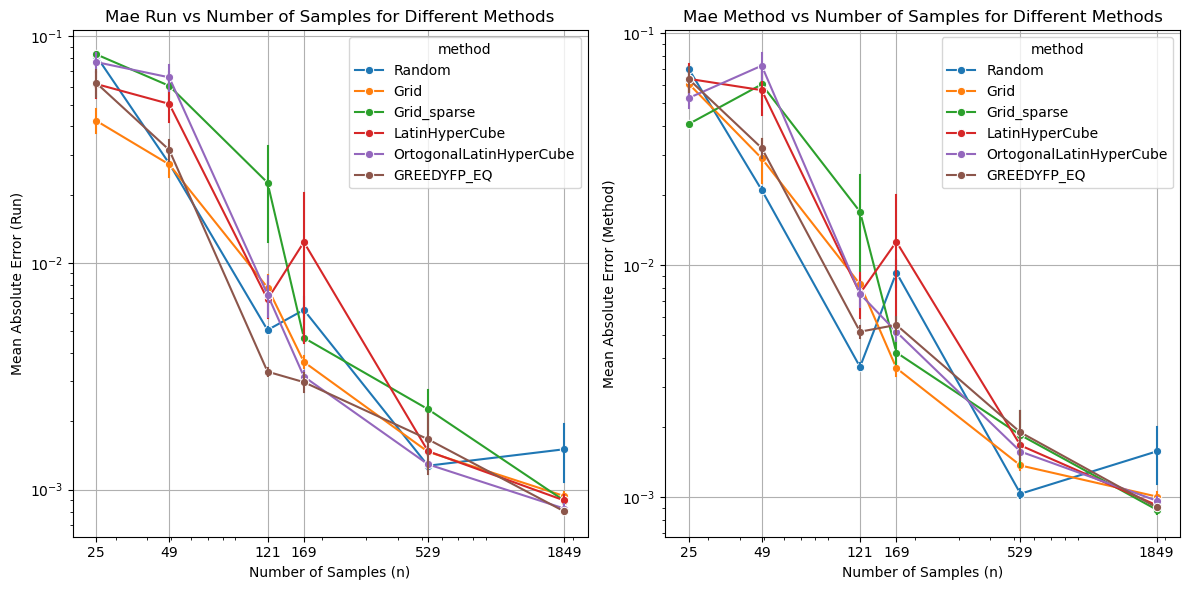

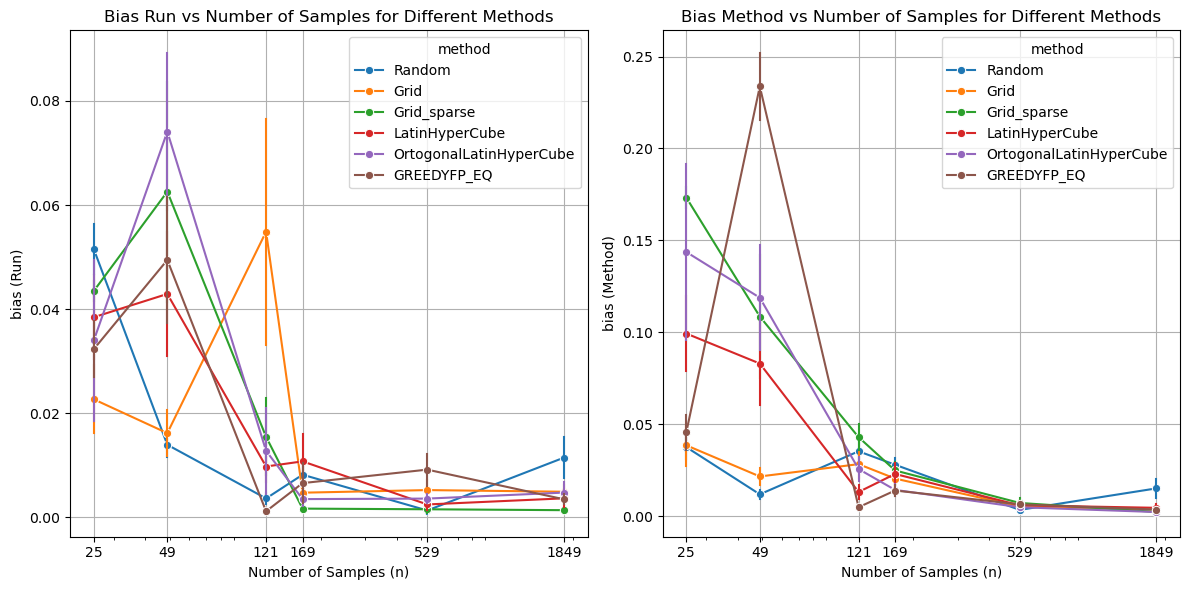

In [168]:
methods = ['Random', 'Grid', 'Grid_sparse', 'LatinHyperCube', 'OrtogonalLatinHyperCube', 'GREEDYFP_EQ'] # All samples
plot_results_seaborn(df_10, methods, 'mae')
plot_results_seaborn(df_10, methods, 'bias')

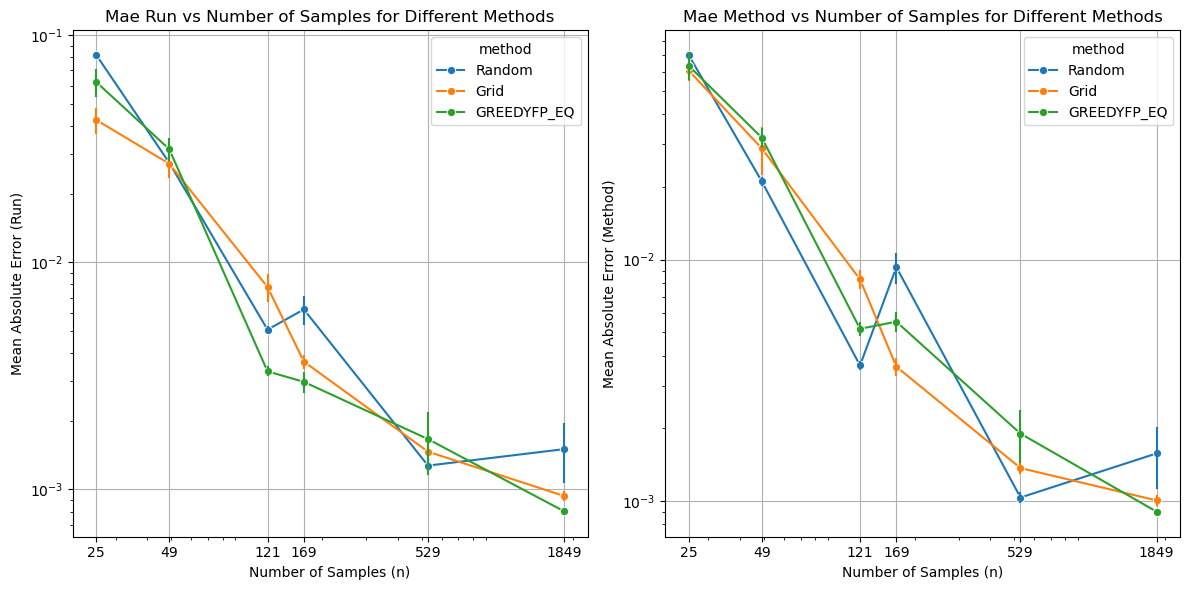

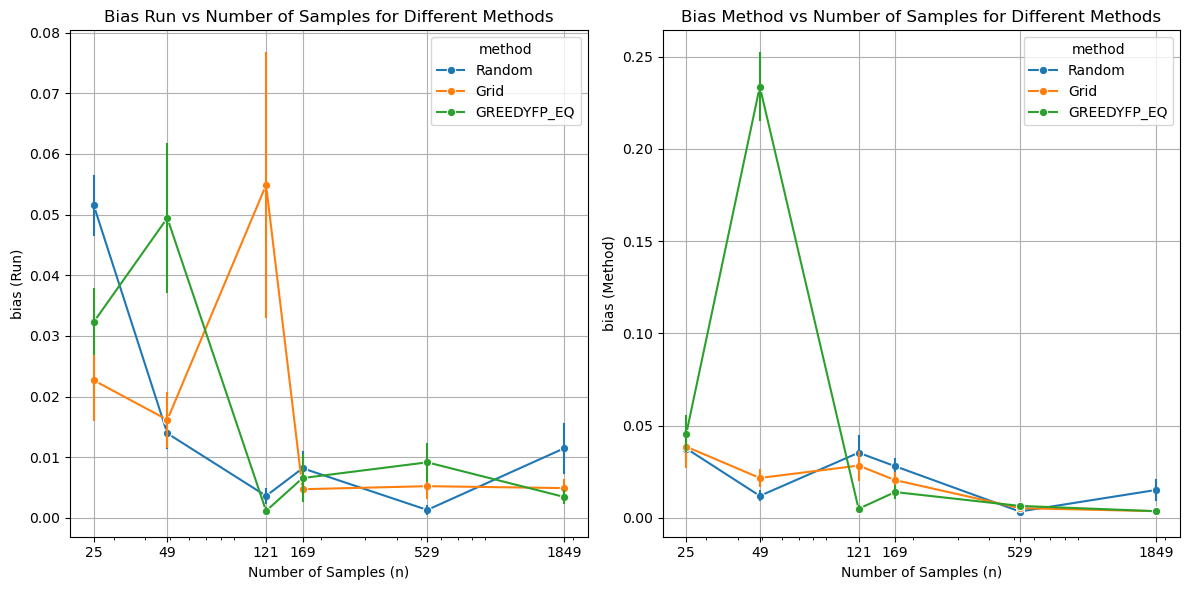

In [159]:
methods = ['GREEDYFP_EQ', 'Random', 'Grid'] # Good performance all around
plot_results_seaborn(df_10, methods, 'mae')
plot_results_seaborn(df_10, methods, 'bias')

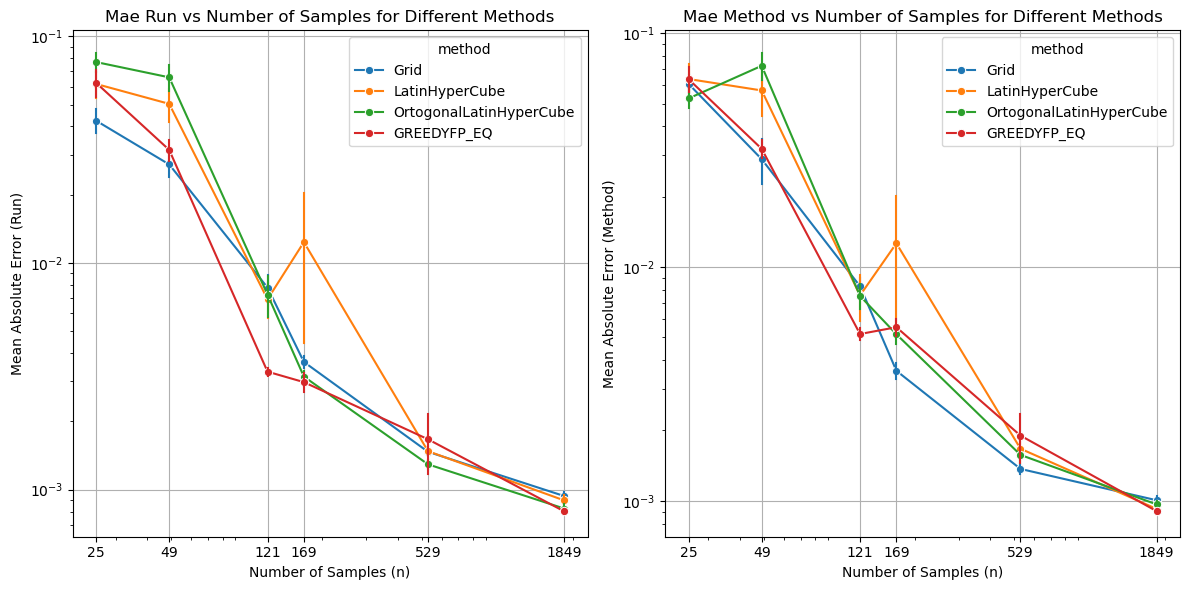

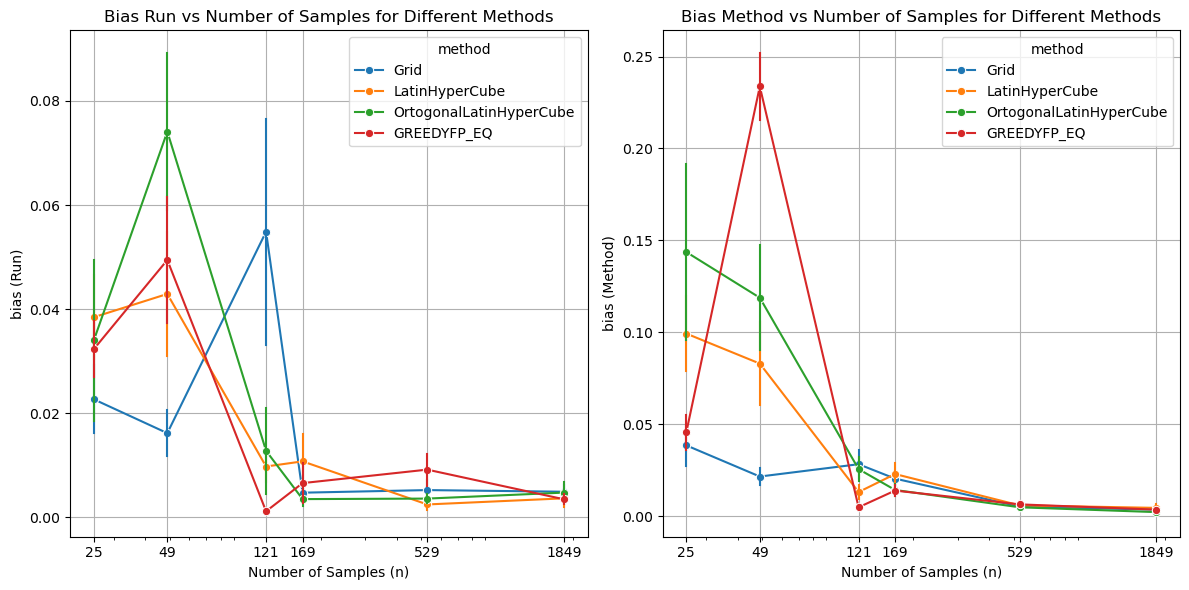

In [166]:
methods = ['LatinHyperCube', 'OrtogonalLatinHyperCube', 'GREEDYFP_EQ', 'Grid'] # Complex methods
plot_results_seaborn(df_10, methods, 'mae')
plot_results_seaborn(df_10, methods, 'bias')

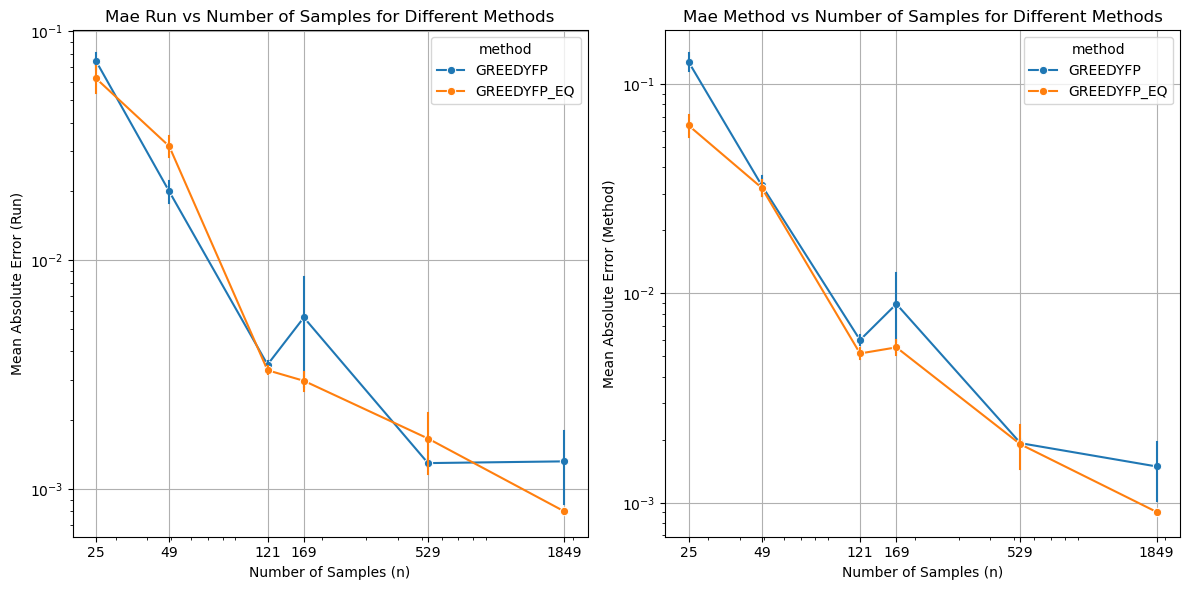

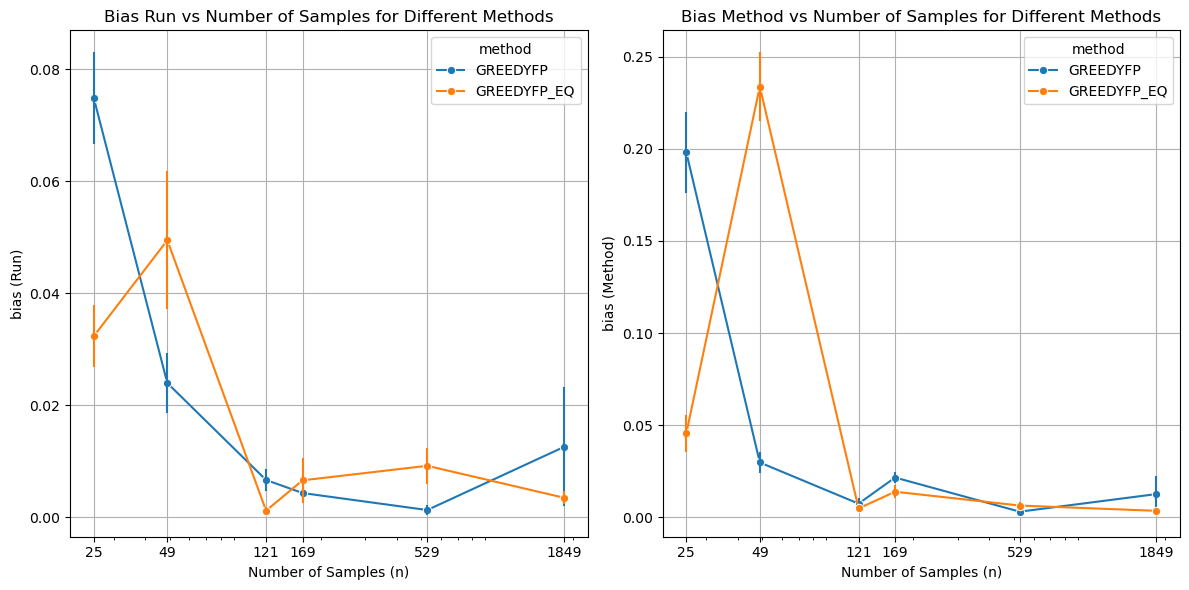

In [161]:
methods = ['GREEDYFP', 'GREEDYFP_EQ'] # Diff between space equal distances.
plot_results_seaborn(df_10, methods, 'mae')
plot_results_seaborn(df_10, methods, 'bias')

In [22]:
# df.to_csv(f"data/experiments/exploration/{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")